## EBM 결과로 What-if 인사이트 찾기


In [2]:
### 전략
# + Fill na 만 할때 성능이 가장 좋음(log, category trick, interaction term 다 필요 없음)
# + overrallqual 의 importance가 가장 높음
# + 너

### Library

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
## sklearn.preprocessing.Imputer -> sklearn.impute.SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os
# print(os.listdir("../input"))

### Load housing data

In [3]:
df_train = pd.read_csv("../data/raw/house/train.csv")
df_test = pd.read_csv("../data/raw/house/test.csv")

In [4]:
print(df_train.shape, df_test.shape)

(1460, 81) (1459, 80)


### Data Exploration

In [5]:
## sample train
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
#Show all columns
pd.options.display.max_columns = None
df_train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

In [7]:
pd.options.display.max_columns = None
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [8]:
## 변수별 type
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
## convert numeric to string
df_train["MSSubClass"] = df_train["MSSubClass"].apply(str)
df_train['YrSold'] = df_train['YrSold'].apply(str)
df_train['MoSold'] = df_train['MoSold'].apply(str)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   object 
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Missing Data

In [10]:
df_na = (df_train.isnull().sum() / len(df_train)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({"Missing Ratio": df_na})

df_na_cols = pd.DataFrame(df_train.dtypes)
missing_data = missing_data.join(df_na_cols, how = 'left')

In [11]:
missing_data

Missing Ratio        0
PoolQC            99.520548   object
MiscFeature       96.301370   object
Alley             93.767123   object
Fence             80.753425   object
FireplaceQu       47.260274   object
LotFrontage       17.739726  float64
GarageType         5.547945   object
GarageYrBlt        5.547945  float64
GarageFinish       5.547945   object
GarageQual         5.547945   object
GarageCond         5.547945   object
BsmtExposure       2.602740   object
BsmtFinType2       2.602740   object
BsmtFinType1       2.534247   object
BsmtCond           2.534247   object
BsmtQual           2.534247   object
MasVnrArea         0.547945  float64
MasVnrType         0.547945   object
Electrical         0.068493   object

In [12]:
len(missing_data)

19

## Profiling report

In [13]:
## profile report -> save html
from pandas_profiling import ProfileReport
# profile = ProfileReport(df_train,
#                        explortative = True,
#                        )

pr = df_train.profile_report()

# pr.to_file('./data_profile/03_01_housing_profile.html')

## Target analysis
### Distribution of target is skewed -> Log transform

/Users/a420777/opt/anaconda3/envs/whatif/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/a420777/opt/anaconda3/envs/whatif/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

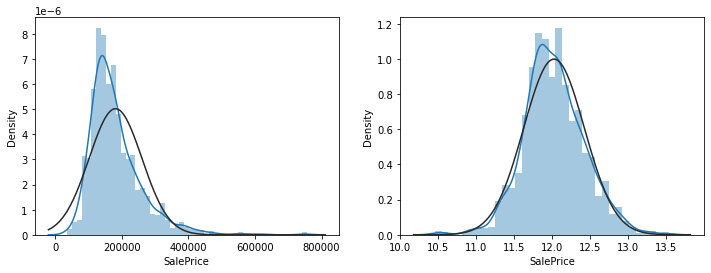

In [14]:
fig, ax = plt.subplots(1, 2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(df_train['SalePrice'], ax = ax[0], fit = norm)
sns.distplot(np.log(df_train[('SalePrice')]+1), ax = ax[1], fit=norm)

## Data Engineering
+ Handling categoricals
+ Feature engineering - To generate new features

### Fill missing value

In [15]:
## Fill with the supplied value
def fill_missing(df, cols, val):
    for col in cols:
        df[col] = df[col].fillna(val)
        
## Fill with the mode
def fill_missing_with_mode(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        
## log transform for columns
def add_log(res, cols):
    m = res.shape[1]
    for col in cols:
        res = res.assign(newcol = pd.Series(np.log(1.01 + res[col])).values)
        res.columns.values[m] = col + '_log'
        m +=1
    
    return res

In [16]:
cat_null_cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu","GarageType", "GarageFinish", "GarageQual", "GarageCond",
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                "MasVnrType", "MSSubClass", "Electrical"]

num_null_cols = ['GarageYrBlt', 'MasVnrArea']

fill_missing(df_train, cat_null_cols, "None")
fill_missing(df_train, num_null_cols, 0)

# house co located are similar in size
df_train['LotFrontage'] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

### Add new feature

In [17]:
## total square feet
df_train["TotalSF"] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

### Handle categorical value
+ EBM에선 categorical value를 dummy로 만드는게 역효과!!

In [18]:
# def dummy_encode(in_df_train):
#     df_train = in_df_train
#     categorical_features = [col  for col in df_train.columns if df_train[col].dtype == 'object']
#     print(categorical_features)
    
#     for f in categorical_features:
#         prefix = f
#         df_train = pd.concat([df_train, pd.get_dummies(df_train[f], prefix = prefix)], axis=1).drop(f,axis=1)
        
#     return df_train

In [19]:
# df_train = dummy_encode(df_train)
# print(df_train.shape)

## Modeling(EBM)

In [20]:
# interpretml EBM
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree

X = df_train.drop(['Id', 'SalePrice'], axis= 1)
y = df_train.SalePrice

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state= 42)

In [21]:
marginal = Marginal().explain_data(X_train, y_train, name = 'Train Data')
show(marginal)

<!-- http://127.0.0.1:7567/140284046491088/ -->

In [22]:
# Explainable boosting regressor
ebm = ExplainableBoostingRegressor(random_state= 42)
ebm.fit(X_train, y_train)


ExplainableBoostingRegressor(feature_names=['MSSubClass', 'MSZoning',
                                            'LotFrontage', 'LotArea', 'Street',
                                            'Alley', 'LotShape', 'LandContour',
                                            'Utilities', 'LotConfig',
                                            'LandSlope', 'Neighborhood',
                                            'Condition1', 'Condition2',
                                            'BldgType', 'HouseStyle',
                                            'OverallQual', 'OverallCond',
                                            'YearBuilt', 'YearRemodAdd',
                                            'RoofStyle', 'RoofMatl',
                                            'Exterior1st', 'Exterior2nd',
                                            'MasVnrTy...
                                            'categorical', 'categorical',
                                            'categorical', 'cate

In [23]:
 #performance
from interpret.perf import RegressionPerf
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_valid, y_valid, name = 'EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7567/140283713183504/ -->

In [143]:
# ebm global
ebm_global = ebm.explain_global(name = 'EBM')
show(ebm_global)

<!-- http://127.0.0.1:7567/140283820395792/ -->

In [144]:
import copy

In [155]:
fig_data=copy.deepcopy(ebm_global._internal_obj)

In [156]:
# data=fig_data["mli"][0]['value']["feature_list"][0]

# names만 하나의 값이 더 많은 현상, 이를 수정하는 로직이 필요함
# 그러나 어떤 규칙인지 알 수 없음. 관찰한 결과는 실제 값이 없는 영역에 일정한 간격을 채우기 위해 만들어 주는 것으로 보임.
data=fig_data["specific"][3]

In [158]:
data.keys()
data.pop("type")
scores_range=data.pop("scores_range")
density=data.pop("density")
data['names']=data['names'][:-1] # 
data=pd.DataFrame(data)

In [159]:
data

names        scores  upper_bounds  lower_bounds
0     1300.0  -6413.110305  -5735.097408  -7091.123202
1     1638.0  -6291.077981  -5627.153723  -6955.002239
2     1774.5  -6291.077981  -5627.153723  -6955.002239
3     1995.0  -6291.077981  -5627.153723  -6955.002239
4     2188.5  -6291.077981  -5627.153723  -6955.002239
..       ...           ...           ...           ...
250  25379.0   7912.290170  10513.191854   5311.388487
251  28174.0   7912.290170  10513.191854   5311.388487
252  35446.5  11253.272897  16572.789433   5933.756361
253  48430.0  11509.850070  15989.119336   7030.580805
254  60543.5  10982.812464  14844.741269   7120.883660

[255 rows x 4 columns]

In [160]:
scores_range=(-98365.92454651206, 102145.65757499124)

In [161]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_time_series(dff, title):
    trace1 = go.Line(
        x=dff['names'],
        y=dff['scores'],
        name='scores',
        marker=dict(
            color='rgb(34,163,192)',
            size=1),
        line_shape="vh",
        line_dash="solid"
    )
    trace2 = go.Scatter(
        x=dff['names'],
        y=dff['upper_bounds'],
        name='upper_bounds',
        marker=dict(
            color='rgb(12,100,100)',
            size=0.1),
        line_shape="vh",
        line_dash="solid"
    )
    
    trace3 = go.Scatter(
        x=dff['names'],
        y=dff['lower_bounds'],
        name='lower_bounds',
        marker=dict(
            color='rgb(200,1,100)',
            size=0.1),
        line_shape="vh",
        line_dash="solid"
    )
    
    fig = make_subplots()
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.add_trace(trace3)

    fig.update_xaxes(showgrid=False)
    fig.update_layout(height=400,width=400*1.618, yaxis_range=list(scores_range))

    return fig

In [162]:
import plotly

/Users/a420777/opt/anaconda3/envs/whatif/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




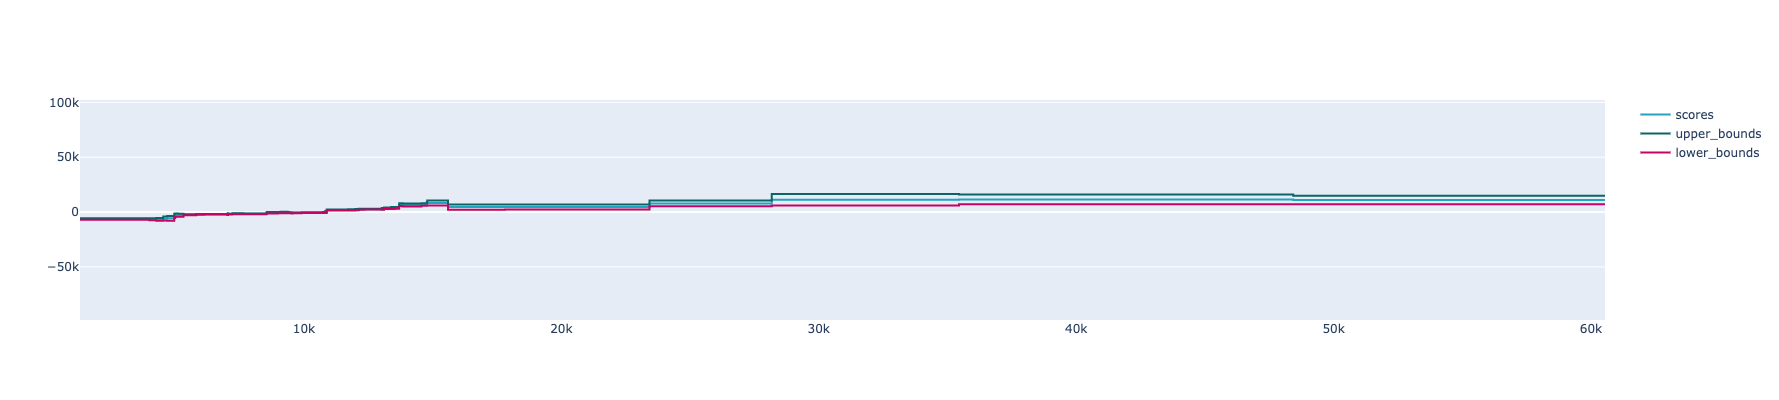

In [163]:
create_time_series(data,"dd")

# Hypothesis 1 - 집 가격의 중요한 feature들과 그들의 영향도

## 1) 인사이트: 전체 매물 관점에서 보았을 때 가격 결정에 기여하는 핵심 특성
- 인사이트: 이 분석을 하면 뭘 알 수 있는데?
- 전체적으로 봤을 때 어떤 특징이 중요하더냐?를 알 수 있다.

## 2) 액션: 
- 액션: 이 인사이트로 뭘 할 수 있는데?

중요도를 기반으로 나눈다? -> 전체를 볼 자원이 없을 때 유용할 것.  
중요도는 가중치를 의미함. 즉, 어떤 피처를 얼마만큼 볼 것인지에 대한 판단 기준이 될 수 있음  

2번 가설의 액션을 위한 보조?



## 3) 분석
- 분석: 실제로 그 인사이트를 가지고 액션까지 가져갈 수 있어?  

- 일부 피처만 가지고 예측 돌려도 어느 정도의 성능이 나온다? 

## 4) 예시
- 예시: 그 구체적인 예시를 보여줘봐

# Hypothesis 2 - 어떤 x를 바꾸어야 집 가격을 가장 많이 올릴 수 있을까?

## 1) (분석 결과 얻을 수 있는) 인사이트: 매물에 따라 기대 수익이 큰 보수/리모델링 선택지의 특성

## 2) 액션: 투입 비용 대비 기대 수익이 큰 리모델링 선택지를 추천

## 3) 분석: 저렴한 매물과 비싼 매물이 각각 있을 때, 기대 수익이 큰 선택지는? 샘플마다 얼마나 다른 결과가 나오는가?  

### 분석 방법  
- validation set에서 가격 기준 하위 2.5% 매물과 상위 2.5% 매물을 조사  
- 수정 불가능한 특성(부동산의 크기, 위치 등)을 제외하고, 수정 가능한 요인 중 각각 기대 변인을 시뮬레이션

In [94]:
# 하위 2.5% 기준 가격
lower_base=y_valid.quantile(0.025)

# 상위 2.5% 기준 가격
upper_base=y_valid.quantile(0.975)

In [95]:
lower_indices=y_valid[y_valid<=lower_base].index
upper_indices=y_valid[y_valid>=upper_base].index

In [173]:
unchangable_features=['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','Condition2',
                     'BldgType','HouseStyle','MasVnrType','MasVnrArea','Foundation','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                     'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
                     'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','PoolArea','3SsnPorch','EnclosedPorch','ScreenPorch','TotalSF']

In [174]:
changable_features=set(X_train.columns)-set(unchangable_features)

In [175]:
changable_features=list(changable_features)

In [99]:
X_lower=X_valid[X_valid.index.isin(lower_indices)]
X_upper=X_valid[X_valid.index.isin(upper_indices)]

In [176]:
changable_features

['GarageType',
 'GarageQual',
 'SaleType',
 'BsmtFinType2',
 'Functional',
 'Utilities',
 'RoofStyle',
 'GarageYrBlt',
 'Fireplaces',
 'ExterCond',
 'YearBuilt',
 'OverallCond',
 'BsmtFinType1',
 'YearRemodAdd',
 'KitchenQual',
 'FireplaceQu',
 'Fence',
 'BsmtCond',
 'Exterior2nd',
 'MiscVal',
 'MiscFeature',
 'BsmtQual',
 'RoofMatl',
 'Electrical',
 'ExterQual',
 'MoSold',
 'OverallQual',
 'Exterior1st',
 'PoolQC',
 'HeatingQC',
 'PavedDrive',
 'SaleCondition',
 'Heating',
 'GarageCond',
 'YrSold',
 'GarageFinish',
 'CentralAir']

In [105]:
ebm_local_lower = ebm.explain_local(X_lower, y_valid[y_valid<=lower_base], name='EBM')
show(ebm_local_lower)

<!-- http://127.0.0.1:7567/140283781711760/ -->

In [106]:
ebm_local_upper = ebm.explain_local(X_upper, y_valid[y_valid>=upper_base], name='EBM')
show(ebm_local_upper)

<!-- http://127.0.0.1:7567/140283807361936/ -->

In [33]:
test_sample=pd.DataFrame(X_valid.iloc[5]).T

In [65]:
test_sample["GarageCond"]="None"

In [66]:
ebm.predict(test_sample)

array([74340.56820046])

In [63]:
test_sample["OverallQual"]="4"

In [64]:
ebm.predict(test_sample)

array([74340.56820046])

In [67]:
test_sample["GarageCars"]="2"

In [68]:
ebm.predict(test_sample)

array([77090.21613942])

In [70]:
test_sample["FullBath"]="2"

In [71]:
ebm.predict(test_sample)

array([81708.88842488])

In [69]:
X_train.FullBath.value_counts()

2    625
1    511
3     27
0      5
Name: FullBath, dtype: int64

# 상위 부정 요인 피처 정보
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)  
GrLivArea: Above grade (ground) living area square feet  
LotArea: Lot size in square feet  
1stFlrSF: First Floor square feet

GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

## 4) 예시
- 예시: 그 구체적인 예시를 보여줘봐

# Hypothesis 3 - x별 집 가격을 가장 크게 변화시키는 Change Point?

## 1) 인사이트: 집 관리, 리모델링 시 민감하게 처리해야하는 매물 특성
- 인사이트: 이 분석을 하면 뭘 알 수 있는데?
- 집 관리, 리모델링 시 민감하게 처리해야하는 매물 특성

## 2) 액션: 부동산 관리/리모델링 컨설팅
- 액션: 이 인사이트로 뭘 할 수 있는데?



## 3) 분석: 부동산 관리/리모델링/설계 시 신중하게 고려해야하는 부분이 있는가? 그 정도는 다른 구간과 비교해 보았을 때 얼마나 차이나는가?
- 분석: 실제로 그 인사이트를 가지고 액션까지 가져갈 수 있어?  

## 4) 예시
- 예시: 그 구체적인 예시를 보여줘봐